In [1]:
#pip install lightgbm xgboost

## Setting up and overview

In [2]:
%matplotlib inline

In [3]:
## Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
## Get multiple outputs in the same cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Ignore all warnings
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [5]:
## Display all rows and columns of a dataframe instead of a truncated version
from IPython.display import display
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [6]:
## Reading the dataset
# This might be present in S3, or obtained through a query on a database
df = pd.read_csv('Churn_Modelling.csv')

In [7]:
df.shape

(10000, 14)

In [8]:
df.head(10).T

,0,1,2,3,4,5,6,7,8,9
RowNumber,1,2,3,4,5,6,7,8,9,10
CustomerId,15634602,15647311,15619304,15701354,15737888,15574012,15592531,15656148,15792365,15592389
Surname,Hargrave,Hill,Onio,Boni,Mitchell,Chu,Bartlett,Obinna,He,H?
CreditScore,619,608,502,699,850,645,822,376,501,684
Geography,France,Spain,France,France,Spain,Spain,France,Germany,France,France
Gender,Female,Female,Female,Female,Female,Male,Male,Female,Male,Male
Age,42,41,42,39,43,44,50,29,44,27
Tenure,2,1,8,1,2,8,7,4,4,2
Balance,0,83807.9,159661,0,125511,113756,0,115047,142051,134604
NumOfProducts,1,1,3,2,1,2,2,4,2,1


### Basic EDA

In [9]:
df.describe() # Describe all numerical columns
df.describe(include = ['O']) # Describe all non-numerical/categorical columns

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


,Surname,Geography,Gender
count,10000,10000,10000
unique,2932,3,2
top,Smith,France,Male
freq,32,5014,5457


In [10]:
## Checking number of unique customers in the dataset
df.shape[0], df.CustomerId.nunique()

(10000, 10000)

In [11]:
df_t = df.groupby(['Surname']).agg({'RowNumber':'count', 'Exited':'mean'}
                                  ).reset_index().sort_values(by='RowNumber', ascending=False)

In [12]:
df_t.head()

,Surname,RowNumber,Exited
2473,Smith,32,0.281250
1689,Martin,29,0.310345
2389,Scott,29,0.103448
2751,Walker,28,0.142857
336,Brown,26,0.192308


In [13]:
df.Geography.value_counts(normalize=True)

France     0.5014
Germany    0.2509
Spain      0.2477
Name: Geography, dtype: float64

In [14]:
## Separating out different columns into various categories as defined above
target_var = ['Exited']
cols_to_remove = ['RowNumber', 'CustomerId']
num_feats = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
cat_feats = ['Surname', 'Geography', 'Gender', 'HasCrCard', 'IsActiveMember']

Tenure and NumOfProducts are ordinal variables. HasCrCard and IsActiveMember are binary categorical variables.

In [15]:
## Removing the non-essential columns
y = df[target_var].values
df.drop(cols_to_remove, axis=1, inplace=True)

### Setting up train, test, and validation sets

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
## Keeping aside a test/holdout set
df_train_val, df_test, y_train_val, y_test = train_test_split(df, y.ravel(), test_size = 0.1, random_state = 42)

## Splitting into train and validation set
df_train, df_val, y_train, y_val = train_test_split(df_train_val, y_train_val, test_size = 0.12, random_state = 42)

In [18]:
df_train.shape, df_val.shape, df_test.shape, y_train.shape, y_val.shape, y_test.shape
np.mean(y_train), np.mean(y_val), np.mean(y_test)

((7920, 12), (1080, 12), (1000, 12), (7920,), (1080,), (1000,))

(0.20303030303030303, 0.22037037037037038, 0.191)

### Comparing various algorithms


- Automate data preparation and model run through Pipelines

- Model Zoo : List of all models to compare

- Evaluate using k-fold Cross validation

In [19]:
from sklearn.base import BaseEstimator, TransformerMixin

In [20]:
class CategoricalEncoder(BaseEstimator, TransformerMixin):
    """ 
    Encodes categorical columns using LabelEncoding, OneHotEncoding and TargetEncoding.
    LabelEncoding is used for binary categorical columns
    OneHotEncoding is used for columns with <= 10 distinct values
    TargetEncoding is used for columns with higher cardinality (>10 distinct values)
    
    """

    def __init__(self, cols = None, lcols = None, ohecols = None, tcols = None, reduce_df = False):
        """
        
        Parameters
        ----------
        cols : list of str
            Columns to encode.  Default is to one-hot/target/label encode all categorical columns in the DataFrame.
        reduce_df : bool
            Whether to use reduced degrees of freedom for encoding
            (that is, add N-1 one-hot columns for a column with N 
            categories). E.g. for a column with categories A, B, 
            and C: When reduce_df is True, A=[1, 0], B=[0, 1],
            and C=[0, 0].  When reduce_df is False, A=[1, 0, 0], 
            B=[0, 1, 0], and C=[0, 0, 1]
            Default = False
        
        """
        
        if isinstance(cols,str):
            self.cols = [cols]
        else :
            self.cols = cols
        
        if isinstance(lcols,str):
            self.lcols = [lcols]
        else :
            self.lcols = lcols
        
        if isinstance(ohecols,str):
            self.ohecols = [ohecols]
        else :
            self.ohecols = ohecols
        
        if isinstance(tcols,str):
            self.tcols = [tcols]
        else :
            self.tcols = tcols
        
        self.reduce_df = reduce_df
    
    
    def fit(self, X, y):
        """Fit label/one-hot/target encoder to X and y
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to encode
        y : pandas Series, shape = [n_samples]
            Target values.
            
        Returns
        -------
        self : encoder
            Returns self.
        """
        
        # Encode all categorical cols by default
        if self.cols is None:
            self.cols = [c for c in X if str(X[c].dtype)=='object']

        # Check columns are in X
        for col in self.cols:
            if col not in X:
                raise ValueError('Column \''+col+'\' not in X')
        
        # Separating out lcols, ohecols and tcols
        if self.lcols is None:
            self.lcols = [c for c in self.cols if X[c].nunique() <= 2]
        
        if self.ohecols is None:
            self.ohecols = [c for c in self.cols if ((X[c].nunique() > 2) & (X[c].nunique() <= 10))]
        
        if self.tcols is None:
            self.tcols = [c for c in self.cols if X[c].nunique() > 10]
        
        
        ## Create Label Encoding mapping
        self.lmaps = dict()
        for col in self.lcols:
            self.lmaps[col] = dict(zip(X[col].values, X[col].astype('category').cat.codes.values))
        
        
        ## Create OneHot Encoding mapping
        self.ohemaps = dict() #dict to store map for each column
        for col in self.ohecols:
            self.ohemaps[col] = []
            uniques = X[col].unique()
            for unique in uniques:
                self.ohemaps[col].append(unique)
            if self.reduce_df:
                del self.ohemaps[col][-1]
        
        
        ## Create Target Encoding mapping
        self.global_target_mean = y.mean().round(2)
        self.sum_count = dict()
        for col in self.tcols:
            self.sum_count[col] = dict()
            uniques = X[col].unique()
            for unique in uniques:
                ix = X[col]==unique
                self.sum_count[col][unique] = (y[ix].sum(),ix.sum())
        
        
        ## Return the fit object
        return self
    
    
    def transform(self, X, y=None):
        """Perform label/one-hot/target encoding transformation.
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to label encode
            
        Returns
        -------
        pandas DataFrame
            Input DataFrame with transformed columns
        """
        
        Xo = X.copy()
        ## Perform label encoding transformation
        for col, lmap in self.lmaps.items():
            
            # Map the column
            Xo[col] = Xo[col].map(lmap)
            Xo[col].fillna(-1, inplace=True) ## Filling new values with -1
        
        
        ## Perform one-hot encoding transformation
        for col, vals in self.ohemaps.items():
            for val in vals:
                new_col = col+'_'+str(val)
                Xo[new_col] = (Xo[col]==val).astype('uint8')
            del Xo[col]
        
        
        ## Perform LOO target encoding transformation
        # Use normal target encoding if this is test data
        if y is None:
            for col in self.sum_count:
                vals = np.full(X.shape[0], np.nan)
                for cat, sum_count in self.sum_count[col].items():
                    vals[X[col]==cat] = (sum_count[0]/sum_count[1]).round(2)
                Xo[col] = vals
                Xo[col].fillna(self.global_target_mean, inplace=True) # Filling new values by global target mean

        # LOO target encode each column
        else:
            for col in self.sum_count:
                vals = np.full(X.shape[0], np.nan)
                for cat, sum_count in self.sum_count[col].items():
                    ix = X[col]==cat
                    if sum_count[1] > 1:
                        vals[ix] = ((sum_count[0]-y[ix].reshape(-1,))/(sum_count[1]-1)).round(2)
                    else :
                        vals[ix] = ((y.sum() - y[ix])/(X.shape[0] - 1)).round(2) # Catering to the case where a particular 
                                                                                 # category level occurs only once in the dataset
                
                Xo[col] = vals
                Xo[col].fillna(self.global_target_mean, inplace=True) # Filling new values by global target mean
        
        
        ## Return encoded DataFrame
        return Xo
    
    
    def fit_transform(self, X, y=None):
        """Fit and transform the data via label/one-hot/target encoding.
        
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to encode
        y : pandas Series, shape = [n_samples]
            Target values (required!).

        Returns
        -------
        pandas DataFrame
            Input DataFrame with transformed columns
        """
        
        return self.fit(X, y).transform(X, y)
    


In [21]:
class AddFeatures(BaseEstimator):
    """
    Add new, engineered features using original categorical and numerical features of the DataFrame
    """
    
    def __init__(self, eps = 1e-6):
        """
        Parameters
        ----------
        eps : A small value to avoid divide by zero error. Default value is 0.000001
        """
        
        self.eps = eps
    
    
    def fit(self, X, y=None):
        return self
    
    
    def transform(self, X):
        """
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing base columns using which new interaction-based features can be engineered
        """
        Xo = X.copy()
        ## Add 4 new columns - bal_per_product, bal_by_est_salary, tenure_age_ratio, age_surname_mean_churn
        Xo['bal_per_product'] = Xo.Balance/(Xo.NumOfProducts + self.eps)
        Xo['bal_by_est_salary'] = Xo.Balance/(Xo.EstimatedSalary + self.eps)
        Xo['tenure_age_ratio'] = Xo.Tenure/(Xo.Age + self.eps)
        Xo['age_surname_enc'] = np.sqrt(Xo.Age) * Xo.Surname
        
        ## Returning the updated dataframe
        return Xo
    
    
    def fit_transform(self, X, y=None):
        """
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing base columns using which new interaction-based features can be engineered
        """
        return self.fit(X,y).transform(X)
    
    

In [22]:
class CustomScaler(BaseEstimator, TransformerMixin):
    """
    A custom standard scaler class with the ability to apply scaling on selected columns
    """
    
    def __init__(self, scale_cols = None):
        """
        Parameters
        ----------
        scale_cols : list of str
            Columns on which to perform scaling and normalization. Default is to scale all numerical columns
        
        """
        self.scale_cols = scale_cols
    
    
    def fit(self, X, y=None):
        """
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to scale
        """
        
        # Scaling all non-categorical columns if user doesn't provide the list of columns to scale
        if self.scale_cols is None:
            self.scale_cols = [c for c in X if ((str(X[c].dtype).find('float') != -1) or (str(X[c].dtype).find('int') != -1))]
        
     
        ## Create mapping corresponding to scaling and normalization
        self.maps = dict()
        for col in self.scale_cols:
            self.maps[col] = dict()
            self.maps[col]['mean'] = np.mean(X[col].values).round(2)
            self.maps[col]['std_dev'] = np.std(X[col].values).round(2)
        
        # Return fit object
        return self
    
    
    def transform(self, X):
        """
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to scale
        """
        Xo = X.copy()
        
        ## Map transformation to respective columns
        for col in self.scale_cols:
            Xo[col] = (Xo[col] - self.maps[col]['mean']) / self.maps[col]['std_dev']
        
        
        # Return scaled and normalized DataFrame
        return Xo
    
    
    def fit_transform(self, X, y=None):
        """
        Parameters
        ----------
        X : pandas DataFrame, shape [n_samples, n_columns]
            DataFrame containing columns to scale
        """
        # Fit and return transformed dataframe
        return self.fit(X).transform(X)
    
    

#### Pipeline for a single model

In [23]:
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier

## Importing relevant metrics
from sklearn.metrics import roc_auc_score, f1_score, recall_score, confusion_matrix, classification_report

In [24]:
X = df_train.drop(columns = ['Exited'], axis = 1)
X_val = df_val.drop(columns = ['Exited'], axis = 1)

cols_to_scale = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary', 'bal_per_product', 'bal_by_est_salary', 'tenure_age_ratio'
                ,'age_surname_enc']

In [25]:
weights_dict = {0 : 1.0, 1 : 3.92}

clf = DecisionTreeClassifier(criterion = 'entropy', class_weight = weights_dict, max_depth = 4, max_features = None
                            , min_samples_split = 25, min_samples_leaf = 15)

In [26]:
model = Pipeline(steps = [('categorical_encoding', CategoricalEncoder()),
                          ('add_new_features', AddFeatures()),
                          ('standard_scaling', CustomScaler(cols_to_scale)),
                          ('classifier', clf)
                         ])

In [27]:
# Fit pipeline with training data
model.fit(X,y_train)

Pipeline(steps=[('categorical_encoding',
                 CategoricalEncoder(cols=['Surname', 'Geography', 'Gender'],
                                    lcols=['Gender'], ohecols=['Geography'],
                                    tcols=['Surname'])),
                ('add_new_features', AddFeatures()),
                ('standard_scaling',
                 CustomScaler(scale_cols=['CreditScore', 'Age', 'Balance',
                                          'EstimatedSalary', 'bal_per_product',
                                          'bal_by_est_salary',
                                          'tenure_age_ratio',
                                          'age_surname_enc'])),
                ('classifier',
                 DecisionTreeClassifier(class_weight={0: 1.0, 1: 3.92},
                                        criterion='entropy', max_depth=4,
                                        min_samples_leaf=15,
                                        min_samples_split=25))])

In [28]:
# Predict target values on val data
val_preds = model.predict(X_val)

In [29]:
## Validation metrics
roc_auc_score(y_val, val_preds)
recall_score(y_val, val_preds)
confusion_matrix(y_val, val_preds)
print(classification_report(y_val, val_preds))

0.7477394758378411

0.7436974789915967

array([[633, 209],
       [ 61, 177]])

              precision    recall  f1-score   support

           0       0.91      0.75      0.82       842
           1       0.46      0.74      0.57       238

    accuracy                           0.75      1080
   macro avg       0.69      0.75      0.70      1080
weighted avg       0.81      0.75      0.77      1080



### Model Zoo and k-fold Cross Validation

#### Models: 
- Random Forest
- Light Gardient Bossted Machine
- XGBoost
- Naive Bayes (Gaussian/Multinomial)
- kNN

In [30]:
from sklearn.model_selection import cross_val_score

In [31]:
## Preparing data and a few common model parameters
X = df_train.drop(columns = ['Exited'], axis = 1)
y = y_train.ravel()

weights_dict = {0 : 1.0, 1 : 3.93}
_, num_samples = np.unique(y_train, return_counts = True)
weight = (num_samples[0]/num_samples[1]).round(2)
weight

cols_to_scale = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary', 'bal_per_product', 'bal_by_est_salary', 'tenure_age_ratio'
                ,'age_surname_enc']

3.93

In [32]:
## Importing the models to be tried out
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB, BernoulliNB

In [33]:
## Preparing a list of models to try out in the spot-checking process
def model_zoo(models = dict()):
    # Tree models
    for n_trees in [21, 1001]:
        models['rf_' + str(n_trees)] = RandomForestClassifier(n_estimators = n_trees, n_jobs = -1, criterion = 'entropy'
                                                              , class_weight = weights_dict, max_depth = 6, max_features = 0.6
                                                              , min_samples_split = 30, min_samples_leaf = 20)
        
        models['lgb_' + str(n_trees)] = LGBMClassifier(boosting_type='dart', num_leaves=31, max_depth= 6, learning_rate=0.1
                                                       , n_estimators=n_trees, class_weight=weights_dict, min_child_samples=20
                                                       , colsample_bytree=0.6, reg_alpha=0.3, reg_lambda=1.0, n_jobs=- 1
                                                       , importance_type = 'gain')
        
        models['xgb_' + str(n_trees)] = XGBClassifier(objective='binary:logistic', n_estimators = n_trees, max_depth = 6
                                                      , learning_rate = 0.03, n_jobs = -1, colsample_bytree = 0.6
                                                      , reg_alpha = 0.3, reg_lambda = 0.1, scale_pos_weight = weight)
        
        models['et_' + str(n_trees)] = ExtraTreesClassifier(n_estimators=n_trees, criterion = 'entropy', max_depth = 6
                                                            , max_features = 0.6, n_jobs = -1, class_weight = weights_dict
                                                            , min_samples_split = 30, min_samples_leaf = 20)
    
    # kNN models
    for n in [3,5,11]:
        models['knn_' + str(n)] = KNeighborsClassifier(n_neighbors=n)
    
    # Naive-Bayes models
    models['gauss_nb'] = GaussianNB()
    models['multi_nb'] = MultinomialNB()
    models['compl_nb'] = ComplementNB()
    models['bern_nb'] = BernoulliNB()
    
    return models

In [34]:
## Automation of data preparation and model run through pipelines
def make_pipeline(model):
    '''
    Creates pipeline for the model passed as the argument. Uses standard scaling only in case of kNN models. 
    Ignores scaling step for tree/Naive Bayes models
    '''
    
    if (str(model).find('KNeighborsClassifier') != -1):
        pipe =  Pipeline(steps = [('categorical_encoding', CategoricalEncoder()),
                              ('add_new_features', AddFeatures()),
                              ('standard_scaling', CustomScaler(cols_to_scale)),
                              ('classifier', model)
                             ])
    else :
        pipe =  Pipeline(steps = [('categorical_encoding', CategoricalEncoder()),
                              ('add_new_features', AddFeatures()),
                              ('classifier', model)
                             ])
    
    
    return pipe


In [35]:
## Run/Evaluate all 15 models using KFold cross-validation (5 folds)
def evaluate_models(X, y, models, folds = 5, metric = 'recall'):
    results = dict()
    for name, model in models.items():
        # Evaluate model through automated pipelines
        pipeline = make_pipeline(model)
        scores = cross_val_score(pipeline, X, y, cv = folds, scoring = metric, n_jobs = -1)
        
        # Store results of the evaluated model
        results[name] = scores
        mu, sigma = np.mean(scores), np.std(scores)
        # Printing individual model results
        print('Model {}: mean = {}, std_dev = {}'.format(name, mu, sigma))
    
    return results
        

In [36]:
## Spot-checking in action
models = model_zoo()
print('Recall metric')
results = evaluate_models(X, y , models, metric = 'recall')
print('F1-score metric')
results = evaluate_models(X, y , models, metric = 'f1')

Recall metric
Model rf_21: mean = 0.7418954741587818, std_dev = 0.01798484587091027
Model lgb_21: mean = 0.7462529749811342, std_dev = 0.021451811890045795
Model xgb_21: mean = 0.7195197461349432, std_dev = 0.014505096894315908
Model et_21: mean = 0.7419109537354153, std_dev = 0.009736050358715055
Model rf_1001: mean = 0.7356804241403998, std_dev = 0.018676988453970915
Model lgb_1001: mean = 0.6262340124997581, std_dev = 0.02347185271419394
Model xgb_1001: mean = 0.6119424933728063, std_dev = 0.018764636123694133
Model et_1001: mean = 0.7344536676921887, std_dev = 0.0063509714842492
Model knn_3: mean = 0.3308391865482479, std_dev = 0.0257896061929066
Model knn_5: mean = 0.30969795476093726, std_dev = 0.01633554361744493
Model knn_11: mean = 0.2506143456976452, std_dev = 0.007246171430455652
Model gauss_nb: mean = 0.03484646194926569, std_dev = 0.015468568191425867
Model multi_nb: mean = 0.5404191095373541, std_dev = 0.022285871235774777
Model compl_nb: mean = 0.5404191095373541, std_de


LightGBM is chosen for further hyperparameter tuning because it has the best performance on recall metric, and it has the second best F1-score

### Hyperparameter tuning

In [37]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from lightgbm import LGBMClassifier

In [38]:
## Preparing data and a few common model parameters
# Unscaled features will be used since it's a tree model

X_train = df_train.drop(columns = ['Exited'], axis = 1)
X_val = df_val.drop(columns = ['Exited'], axis = 1)

X_train.shape, y_train.shape
X_val.shape, y_val.shape

((7920, 11), (7920,))

((1080, 11), (1080,))

In [39]:
lgb = LGBMClassifier(boosting_type = 'dart', min_child_samples = 20, n_jobs = - 1, importance_type = 'gain', num_leaves = 31)

In [40]:
model = Pipeline(steps = [('categorical_encoding', CategoricalEncoder()),
                          ('add_new_features', AddFeatures()),
                          ('classifier', lgb)
                         ])

#### Randomized Search

In [41]:
# Parameters
parameters = {'classifier__n_estimators':[10, 21, 51, 100, 201, 350, 501]
             ,'classifier__max_depth': [3, 4, 6, 9]
             ,'classifier__num_leaves':[7, 15, 31] 
             ,'classifier__learning_rate': [0.03, 0.05, 0.1, 0.5, 1]
             ,'classifier__colsample_bytree': [0.3, 0.6, 0.8]
             ,'classifier__reg_alpha': [0, 0.3, 1, 5]
             ,'classifier__reg_lambda': [0.1, 0.5, 1, 5, 10]
             ,'classifier__class_weight': [{0:1,1:1.0}, {0:1,1:1.96}, {0:1,1:3.0}, {0:1,1:3.93}]
             }

In [42]:
search = RandomizedSearchCV(model, parameters, n_iter = 20, cv = 5, scoring = 'f1')

In [43]:
search.fit(X_train, y_train.ravel())

[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('categorical_encoding',
                                              CategoricalEncoder()),
                                             ('add_new_features',
                                              AddFeatures()),
                                             ('classifier',
                                              LGBMClassifier(boosting_type='dart',
                                                             importance_type='gain'))]),
                   n_iter=20,
                   param_distributions={'classifier__class_weight': [{0: 1,
                                                                      1: 1.0},
                                                                     {0: 1,
                                                                      1: 1.96},
                                                                     {0: 1,
                                                           

In [44]:
search.best_params_
search.best_score_

{'classifier__reg_lambda': 0.1,
 'classifier__reg_alpha': 0,
 'classifier__num_leaves': 31,
 'classifier__n_estimators': 501,
 'classifier__max_depth': 3,
 'classifier__learning_rate': 0.1,
 'classifier__colsample_bytree': 0.8,
 'classifier__class_weight': {0: 1, 1: 1.96}}

0.6253878121241038

In [45]:
search.cv_results_

{'mean_fit_time': array([2.08193316, 1.99100361, 2.06978297, 2.09737086, 2.67868733,
        2.15768538, 2.02263165, 2.12149863, 2.1250361 , 2.04323783,
        2.73519707, 2.08970923, 2.07424064, 2.12578926, 2.69564662,
        2.15392032, 3.15273929, 2.08543482, 2.57885199, 2.22143373]),
 'std_fit_time': array([0.03930249, 0.07176973, 0.049432  , 0.04865532, 0.12491709,
        0.05232948, 0.09432602, 0.07890353, 0.10906243, 0.05811275,
        0.15073194, 0.06954715, 0.11516216, 0.05710052, 0.13127537,
        0.08152674, 0.47054879, 0.12400368, 0.18853384, 0.21085371]),
 'mean_score_time': array([0.38885541, 0.39071307, 0.38706522, 0.37740965, 0.38885322,
        0.37968054, 0.39094687, 0.39544954, 0.38891487, 0.3851769 ,
        0.40530839, 0.4002327 , 0.4057127 , 0.39064317, 0.38995614,
        0.40766625, 0.46900086, 0.38240857, 0.41849179, 0.41464887]),
 'std_score_time': array([0.01519452, 0.0314094 , 0.02041765, 0.01050009, 0.01215216,
        0.00862114, 0.02096417, 0.011363

#### Grid Search

In [46]:
#list of parameters
parameters = {'classifier__n_estimators':[201]
             ,'classifier__max_depth': [6]
             ,'classifier__num_leaves': [63]
             ,'classifier__learning_rate': [0.1]
             ,'classifier__colsample_bytree': [0.6, 0.8]
             ,'classifier__reg_alpha': [0, 1, 10]
             ,'classifier__reg_lambda': [0.1, 1, 5]
             ,'classifier__class_weight': [{0:1,1:3.0}]
             }

In [47]:
grid = GridSearchCV(model, parameters, cv = 5, scoring = 'f1', n_jobs = -1)

In [48]:
grid.fit(X_train, y_train.ravel())

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('categorical_encoding',
                                        CategoricalEncoder()),
                                       ('add_new_features', AddFeatures()),
                                       ('classifier',
                                        LGBMClassifier(boosting_type='dart',
                                                       importance_type='gain'))]),
             n_jobs=-1,
             param_grid={'classifier__class_weight': [{0: 1, 1: 3.0}],
                         'classifier__colsample_bytree': [0.6, 0.8],
                         'classifier__learning_rate': [0.1],
                         'classifier__max_depth': [6],
                         'classifier__n_estimators': [201],
                         'classifier__num_leaves': [63],
                         'classifier__reg_alpha': [0, 1, 10],
                         'classifier__reg_lambda': [0.1, 1, 5]},
             scoring='f1')

In [49]:
grid.best_params_
grid.best_score_

{'classifier__class_weight': {0: 1, 1: 3.0},
 'classifier__colsample_bytree': 0.8,
 'classifier__learning_rate': 0.1,
 'classifier__max_depth': 6,
 'classifier__n_estimators': 201,
 'classifier__num_leaves': 63,
 'classifier__reg_alpha': 0,
 'classifier__reg_lambda': 0.1}

0.6259056069494722

In [50]:
grid.cv_results_

{'mean_fit_time': array([5.2099813 , 5.25012941, 5.20435295, 5.2857688 , 5.33025122,
        5.27810297, 5.2076376 , 5.5487504 , 5.6351769 , 5.92846165,
        6.03670511, 6.27871461, 7.77477536, 7.94699302, 6.93385806,
        6.74822917, 6.5483479 , 4.85989738]),
 'std_fit_time': array([0.12286322, 0.04618009, 0.10291849, 0.16693165, 0.12830587,
        0.10015764, 0.0720434 , 0.21579992, 0.1132886 , 0.0778764 ,
        0.07166464, 0.18074924, 0.95680199, 0.82014141, 0.26838178,
        0.08681724, 0.66386461, 0.30700408]),
 'mean_score_time': array([0.70219841, 0.72798724, 0.7150363 , 0.74597888, 0.74039898,
        0.70888743, 0.71384101, 0.72461734, 0.74158907, 0.81408916,
        0.93657293, 1.09334278, 0.91129761, 0.93277011, 0.90291691,
        0.97337155, 0.84384742, 0.49078498]),
 'std_score_time': array([0.00526729, 0.02057822, 0.02198194, 0.02149089, 0.03657477,
        0.0129825 , 0.01456085, 0.01647242, 0.02524016, 0.10128173,
        0.02605983, 0.20637771, 0.02677914, 

### Ensembles

In [51]:
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline

In [52]:
## Preparing data for error analysis
# Unscaled features will be used since it's a tree model

X_train = df_train.drop(columns = ['Exited'], axis = 1)
X_val = df_val.drop(columns = ['Exited'], axis = 1)

X_train.shape, y_train.shape
X_val.shape, y_val.shape

((7920, 11), (7920,))

((1080, 11), (1080,))

In [53]:
## Three versions of the final model with best params for F1-score metric

# Equal weights to both target classes (no class imbalance correction)
lgb1 = LGBMClassifier(boosting_type = 'dart', class_weight = {0: 1, 1: 1}, min_child_samples = 20, n_jobs = - 1
                     , importance_type = 'gain', max_depth = 4, num_leaves = 31, colsample_bytree = 0.6, learning_rate = 0.1
                     , n_estimators = 21, reg_alpha = 0, reg_lambda = 0.5)

# Addressing class imbalance completely by weighting the undersampled class by the class imbalance ratio
lgb2 = LGBMClassifier(boosting_type = 'dart', class_weight = {0: 1, 1: 3.93}, min_child_samples = 20, n_jobs = - 1
                     , importance_type = 'gain', max_depth = 6, num_leaves = 63, colsample_bytree = 0.6, learning_rate = 0.1
                     , n_estimators = 201, reg_alpha = 1, reg_lambda = 1)


# Best class_weight parameter settings (partial class imbalance correction)
lgb3 = LGBMClassifier(boosting_type = 'dart', class_weight = {0: 1, 1: 3.0}, min_child_samples = 20, n_jobs = - 1
                     , importance_type = 'gain', max_depth = 6, num_leaves = 63, colsample_bytree = 0.6, learning_rate = 0.1
                     , n_estimators = 201, reg_alpha = 1, reg_lambda = 1)


In [54]:
## 3 different Pipeline objects for the 3 models defined above
model_1 = Pipeline(steps = [('categorical_encoding', CategoricalEncoder()),
                          ('add_new_features', AddFeatures()),
                          ('classifier', lgb1)
                         ])

model_2 = Pipeline(steps = [('categorical_encoding', CategoricalEncoder()),
                          ('add_new_features', AddFeatures()),
                          ('classifier', lgb2)
                         ])

model_3 = Pipeline(steps = [('categorical_encoding', CategoricalEncoder()),
                          ('add_new_features', AddFeatures()),
                          ('classifier', lgb3)
                         ])

In [55]:
## Fitting each of these models
model_1.fit(X_train, y_train.ravel())
model_2.fit(X_train, y_train.ravel())
model_3.fit(X_train, y_train.ravel())

Pipeline(steps=[('categorical_encoding',
                 CategoricalEncoder(cols=['Surname', 'Geography', 'Gender'],
                                    lcols=['Gender'], ohecols=['Geography'],
                                    tcols=['Surname'])),
                ('add_new_features', AddFeatures()),
                ('classifier',
                 LGBMClassifier(boosting_type='dart', class_weight={0: 1, 1: 1},
                                colsample_bytree=0.6, importance_type='gain',
                                max_depth=4, n_estimators=21, reg_alpha=0,
                                reg_lambda=0.5))])

Pipeline(steps=[('categorical_encoding',
                 CategoricalEncoder(cols=['Surname', 'Geography', 'Gender'],
                                    lcols=['Gender'], ohecols=['Geography'],
                                    tcols=['Surname'])),
                ('add_new_features', AddFeatures()),
                ('classifier',
                 LGBMClassifier(boosting_type='dart',
                                class_weight={0: 1, 1: 3.93},
                                colsample_bytree=0.6, importance_type='gain',
                                max_depth=6, n_estimators=201, num_leaves=63,
                                reg_alpha=1, reg_lambda=1))])

Pipeline(steps=[('categorical_encoding',
                 CategoricalEncoder(cols=['Surname', 'Geography', 'Gender'],
                                    lcols=['Gender'], ohecols=['Geography'],
                                    tcols=['Surname'])),
                ('add_new_features', AddFeatures()),
                ('classifier',
                 LGBMClassifier(boosting_type='dart',
                                class_weight={0: 1, 1: 3.0},
                                colsample_bytree=0.6, importance_type='gain',
                                max_depth=6, n_estimators=201, num_leaves=63,
                                reg_alpha=1, reg_lambda=1))])

In [56]:
## Getting prediction probabilities from each of these models
m1_pred_probs_trn = model_1.predict_proba(X_train)
m2_pred_probs_trn = model_2.predict_proba(X_train)
m3_pred_probs_trn = model_3.predict_proba(X_train)

In [57]:
## Checking correlations between the predictions of the 3 models
df_t = pd.DataFrame({'m1_pred': m1_pred_probs_trn[:,1], 'm2_pred': m2_pred_probs_trn[:,1], 'm3_pred': m3_pred_probs_trn[:,1]})
df_t.shape
df_t.corr()

(7920, 3)

,m1_pred,m2_pred,m3_pred
m1_pred,1.000000,0.907405,0.923072
m2_pred,0.907405,1.000000,0.992430
m3_pred,0.923072,0.992430,1.000000


we will form an ensemble of m1 and m2 (model stacking) and see if that improves the model accuracy

In [58]:
## Importing relevant metric libraries
from sklearn.metrics import roc_auc_score, f1_score, recall_score, confusion_matrix, classification_report

In [59]:
## Getting prediction probabilities from each of these models
m1_pred_probs_val = model_1.predict_proba(X_val)
m2_pred_probs_val = model_2.predict_proba(X_val)
m3_pred_probs_val = model_3.predict_proba(X_val)

In [60]:
threshold = 0.5

In [61]:
## Best model (Model 3) predictions
m3_preds = np.where(m3_pred_probs_val[:,1] >= threshold, 1, 0)

In [62]:
## Model averaging predictions (Weighted average)
m1_m2_preds = np.where(((0.1*m1_pred_probs_val[:,1]) + (0.9*m2_pred_probs_val[:,1])) >= threshold, 1, 0)

In [63]:
## Model 3 (Best model, tuned by GridSearch) performance on validation set
roc_auc_score(y_val, m3_preds)
recall_score(y_val, m3_preds)
confusion_matrix(y_val, m3_preds)
print(classification_report(y_val, m3_preds))

0.7605840435936845

0.6470588235294118

array([[736, 106],
       [ 84, 154]])

              precision    recall  f1-score   support

           0       0.90      0.87      0.89       842
           1       0.59      0.65      0.62       238

    accuracy                           0.82      1080
   macro avg       0.74      0.76      0.75      1080
weighted avg       0.83      0.82      0.83      1080



In [64]:
## Ensemble model prediction on validation set
roc_auc_score(y_val, m1_m2_preds)
recall_score(y_val, m1_m2_preds)
confusion_matrix(y_val, m1_m2_preds)
print(classification_report(y_val, m1_m2_preds))

0.7705393321223977

0.6764705882352942

array([[728, 114],
       [ 77, 161]])

              precision    recall  f1-score   support

           0       0.90      0.86      0.88       842
           1       0.59      0.68      0.63       238

    accuracy                           0.82      1080
   macro avg       0.74      0.77      0.76      1080
weighted avg       0.83      0.82      0.83      1080



#### Model stacking

The base models are the 2 LightGBM models with different class_weights parameters. They are stacked on top by a logistic regression model. 

For training, we have the predictions from the 2 models on the train set. They go in as the input to the next layer of the Ensemble, which is the logistic regression model, and train the logistic regression model

For prediction, we first predict using the 2 LGBM models on the validation set. The predictions from the two models go as inputs to the logistic regression which gives out the final prediction

In [65]:
from sklearn.linear_model import LogisticRegression

In [66]:
## Training
lr = LogisticRegression(C = 1.0, class_weight =  {0:1, 1:2.0})

# Concatenating the probability predictions of the 2 models on train set
X_t = np.c_[m1_pred_probs_trn[:,1],m2_pred_probs_trn[:,1]] 

# Fit stacker model on top of outputs of base model
lr.fit(X_t, y_train)

LogisticRegression(class_weight={0: 1, 1: 2.0})

In [67]:
## Prediction
# Concatenating outputs from both the base models on the validation set
X_t_val = np.c_[m1_pred_probs_val[:,1],m2_pred_probs_val[:,1]]

# Predict using the stacker model
m1_m2_preds = lr.predict(X_t_val)

In [68]:
## Ensemble model prediction on validation set
roc_auc_score(y_val, m1_m2_preds)
recall_score(y_val, m1_m2_preds)
confusion_matrix(y_val, m1_m2_preds)
print(classification_report(y_val, m1_m2_preds))

0.770449509970259

0.6596638655462185

array([[742, 100],
       [ 81, 157]])

              precision    recall  f1-score   support

           0       0.90      0.88      0.89       842
           1       0.61      0.66      0.63       238

    accuracy                           0.83      1080
   macro avg       0.76      0.77      0.76      1080
weighted avg       0.84      0.83      0.83      1080



In [69]:
# Model weights learnt by the stacker LogReg model
lr.coef_
lr.intercept_

array([[-2.42377331,  8.62226869]])

array([-4.15402428])

### Error analysis

In [70]:
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline

In [71]:
## Preparing data for error analysis

X_train = df_train.drop(columns = ['Exited'], axis = 1)
X_val = df_val.drop(columns = ['Exited'], axis = 1)

X_train.shape, y_train.shape
X_val.shape, y_val.shape

((7920, 11), (7920,))

((1080, 11), (1080,))

In [72]:
## Final model with best params for F1-score metric

lgb = LGBMClassifier(boosting_type = 'dart', class_weight = {0: 1, 1: 3.0}, min_child_samples = 20, n_jobs = - 1
                     , importance_type = 'gain', max_depth = 6, num_leaves = 63, colsample_bytree = 0.6, learning_rate = 0.1
                     , n_estimators = 201, reg_alpha = 1, reg_lambda = 1)


model = Pipeline(steps = [('categorical_encoding', CategoricalEncoder()),
                          ('add_new_features', AddFeatures()),
                          ('classifier', lgb)
                         ])

In [73]:
## Fit best model
model.fit(X_train, y_train.ravel())

Pipeline(steps=[('categorical_encoding',
                 CategoricalEncoder(cols=['Surname', 'Geography', 'Gender'],
                                    lcols=['Gender'], ohecols=['Geography'],
                                    tcols=['Surname'])),
                ('add_new_features', AddFeatures()),
                ('classifier',
                 LGBMClassifier(boosting_type='dart',
                                class_weight={0: 1, 1: 3.0},
                                colsample_bytree=0.6, importance_type='gain',
                                max_depth=6, n_estimators=201, num_leaves=63,
                                reg_alpha=1, reg_lambda=1))])

In [74]:
## Making predictions on a copy of validation set
df_ea = df_val.copy()
df_ea['y_pred'] = model.predict(X_val)
df_ea['y_pred_prob'] = model.predict_proba(X_val)[:,1]

In [75]:
df_ea.shape
df_ea.sample(5)

(1080, 14)

,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,y_pred,y_pred_prob
162,Treacy,800,France,Female,49,7,108007.36,1,0,0,47125.11,0,1,0.741871
8438,Rogova,707,Germany,Female,48,7,105086.74,1,1,1,180344.69,1,1,0.744854
9729,Tretiakova,651,France,Male,23,10,0.00,2,1,1,170099.23,0,0,0.042162
2352,Nuttall,637,Spain,Female,45,2,157929.45,1,1,1,145134.49,1,0,0.417057
9143,Bailey,676,France,Female,34,8,100359.54,1,0,0,46038.28,0,0,0.147434


<AxesSubplot:>

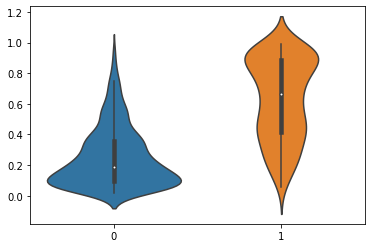

In [76]:
## Visualizing distribution of predicted probabilities
sns.violinplot(y_val.ravel(), df_ea['y_pred_prob'].values)

#### Extracting the subset of incorrect predictions

All incorrect predictions are extracted and categorized into false positives (low precision) and false negatives (low recall)

In [77]:
low_recall = df_ea[(df_ea.Exited == 1) & (df_ea.y_pred == 0)]
low_prec = df_ea[(df_ea.Exited == 0) & (df_ea.y_pred == 1)]
low_recall.shape
low_prec.shape
low_recall.head()
low_prec.head()

(84, 14)

(106, 14)

,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,y_pred,y_pred_prob
1218,Docherty,706,France,Female,23,5,0.00,1,0,0,164128.41,1,0,0.436350
3741,Thompson,738,Germany,Female,29,9,139106.19,1,1,0,141872.05,1,0,0.426364
3212,Hs?,611,France,Male,35,10,0.00,1,1,1,23598.23,1,0,0.197232
5020,Page,491,Germany,Female,68,1,95039.12,1,0,1,116471.14,1,0,0.353437
4918,Bruno,717,France,Female,36,2,99472.76,2,1,0,94274.72,1,0,0.108109


,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,y_pred,y_pred_prob
7335,Owen,651,France,Female,41,4,38617.20,1,1,1,104876.80,0,1,0.537131
162,Treacy,800,France,Female,49,7,108007.36,1,0,0,47125.11,0,1,0.741871
4802,Capon,512,Spain,Male,39,3,0.00,1,1,0,134878.19,0,1,0.590946
7632,Sinnett,736,France,Male,43,4,202443.47,1,1,0,72375.03,0,1,0.686637
4935,Toscani,505,Germany,Male,43,6,127146.68,1,0,0,137565.87,0,1,0.839606


<AxesSubplot:xlabel='y_pred_prob', ylabel='Density'>

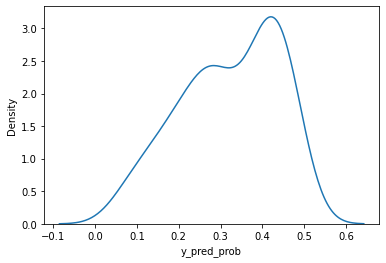

In [78]:
## Prediction probabilty distribution of errors causing low recall
sns.distplot(low_recall.y_pred_prob, hist=False)

<AxesSubplot:xlabel='y_pred_prob', ylabel='Density'>

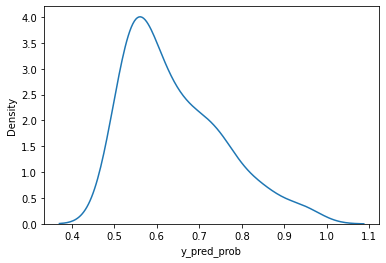

In [79]:
## Prediction probabilty distribution of errors causing low precision
sns.distplot(low_prec.y_pred_prob, hist=False)

### Train final, best model ; Save model and its parameters

In [80]:
from sklearn.pipeline import Pipeline
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, f1_score, recall_score, confusion_matrix, classification_report
import joblib

In [81]:
## Re-defining X_train and X_val to consider original unscaled continuous features. y_train and y_val remain unaffected
X_train = df_train.drop(columns = ['Exited'], axis = 1)
X_val = df_val.drop(columns = ['Exited'], axis = 1)

X_train.shape, y_train.shape
X_val.shape, y_val.shape

((7920, 11), (7920,))

((1080, 11), (1080,))

In [82]:
best_f1_lgb = LGBMClassifier(boosting_type = 'dart', class_weight = {0: 1, 1: 3.0}, min_child_samples = 20, n_jobs = - 1
                     , importance_type = 'gain', max_depth = 6, num_leaves = 63, colsample_bytree = 0.6, learning_rate = 0.1
                     , n_estimators = 201, reg_alpha = 1, reg_lambda = 1)

In [83]:
best_recall_lgb = LGBMClassifier(boosting_type='dart', num_leaves=31, max_depth= 6, learning_rate=0.1, n_estimators = 21
                                 , class_weight= {0: 1, 1: 3.93}, min_child_samples=2, colsample_bytree=0.6, reg_alpha=0.3
                                 , reg_lambda=1.0, n_jobs=- 1, importance_type = 'gain')

In [84]:
model = Pipeline(steps = [('categorical_encoding', CategoricalEncoder()),
                          ('add_new_features', AddFeatures()),
                          ('classifier', best_f1_lgb)
                         ])

In [85]:
## Fitting final model on train dataset
model.fit(X_train, y_train)

Pipeline(steps=[('categorical_encoding',
                 CategoricalEncoder(cols=['Surname', 'Geography', 'Gender'],
                                    lcols=['Gender'], ohecols=['Geography'],
                                    tcols=['Surname'])),
                ('add_new_features', AddFeatures()),
                ('classifier',
                 LGBMClassifier(boosting_type='dart',
                                class_weight={0: 1, 1: 3.0},
                                colsample_bytree=0.6, importance_type='gain',
                                max_depth=6, n_estimators=201, num_leaves=63,
                                reg_alpha=1, reg_lambda=1))])

In [86]:
# Predict target probabilities
val_probs = model.predict_proba(X_val)[:,1]

# Predict target values on val data
val_preds = np.where(val_probs > 0.45, 1, 0) # The probability threshold can be tweaked

<AxesSubplot:>

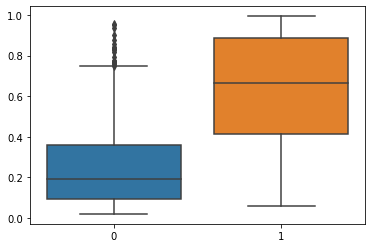

In [87]:
sns.boxplot(y_val.ravel(), val_probs)

In [88]:
## Validation metrics
roc_auc_score(y_val, val_preds)
recall_score(y_val, val_preds)
confusion_matrix(y_val, val_preds)
print(classification_report(y_val, val_preds))

0.7736431864907484

0.7016806722689075

array([[712, 130],
       [ 71, 167]])

              precision    recall  f1-score   support

           0       0.91      0.85      0.88       842
           1       0.56      0.70      0.62       238

    accuracy                           0.81      1080
   macro avg       0.74      0.77      0.75      1080
weighted avg       0.83      0.81      0.82      1080



In [89]:
## Save model object
joblib.dump(model, 'churn_model_f1_0_45.sav')

['churn_model_f1_0_45.sav']

### Load saved model and make predictions on unseen/future data

Here, we'll use df_test as the unseen, future data

In [90]:
import joblib

In [91]:
## Load model object
model = joblib.load('churn_model_f1_0_45.sav')

In [92]:
X_test = df_test.drop(columns = ['Exited'], axis = 1)
X_test.shape
y_test.shape

(1000, 11)

(1000,)

In [93]:
## Predict target probabilities
test_probs = model.predict_proba(X_test)[:,1]

In [94]:
## Predict target values on test data
test_preds = np.where(test_probs > 0.45, 1, 0) # Flexibility to tweak the probability threshold
#test_preds = model.predict(X_test)

<AxesSubplot:>

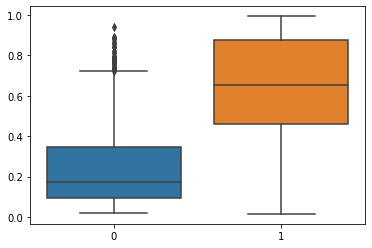

In [95]:
sns.boxplot(y_test.ravel(), test_probs)

In [96]:
## Test set metrics
roc_auc_score(y_test, test_preds)
recall_score(y_test, test_preds)
confusion_matrix(y_test, test_preds)
print(classification_report(y_test, test_preds))

0.79647163132042

0.7486910994764397

array([[683, 126],
       [ 48, 143]])

              precision    recall  f1-score   support

           0       0.93      0.84      0.89       809
           1       0.53      0.75      0.62       191

    accuracy                           0.83      1000
   macro avg       0.73      0.80      0.75      1000
weighted avg       0.86      0.83      0.84      1000



In [97]:
## Adding predictions and their probabilities in the original test dataframe
test = df_test.copy()
test['predictions'] = test_preds
test['pred_probabilities'] = test_probs

In [98]:
test.sample(10)

,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,predictions,pred_probabilities
4049,Burns,618,Spain,Male,33,4,0.00,2,1,1,77550.18,0,0,0.028719
5306,Kaodilinakachukwu,605,France,Female,51,9,104760.82,1,1,1,165574.54,1,1,0.500040
5968,Tai,526,France,Male,28,1,112070.44,1,0,1,126281.83,0,0,0.090424
2184,Ogochukwu,652,France,Female,40,1,0.00,2,1,0,126554.96,0,0,0.133584
7801,Chijindum,678,France,Male,54,7,128914.97,1,0,0,191746.23,1,1,0.901559
3079,Monaldo,757,Germany,Female,34,1,129398.01,2,0,0,44965.44,0,0,0.180424
6120,Lei,715,France,Male,40,7,0.00,1,1,1,141359.11,0,0,0.330511
6410,Chao,689,Spain,Female,63,1,0.00,2,1,1,186526.12,0,0,0.122595
1175,Atkins,719,Spain,Male,39,5,0.00,2,1,0,145759.70,0,0,0.055866
1658,Obialo,748,France,Male,44,2,92911.52,1,0,1,85495.24,0,0,0.313686


#### Creating a list of customers who are the most likely to churn

Listing customers who have a churn probability higher than 70%.

In [99]:
high_churn_list = test[test.pred_probabilities > 0.7].sort_values(by = ['pred_probabilities'], ascending = False).reset_index().drop(columns = ['index', 'Exited', 'predictions'], axis = 1)

In [100]:
high_churn_list.shape
high_churn_list.head()

(120, 12)

,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,pred_probabilities
0,Chibueze,546,Germany,Female,58,3,106458.31,4,1,0,128881.87,0.994313
1,Walton,479,Germany,Male,51,1,107714.74,3,1,0,86128.21,0.988470
2,Galgano,665,Germany,Female,43,2,116322.27,4,1,0,35640.12,0.982883
3,Findlay,515,Germany,Male,45,7,120961.50,3,1,1,39288.11,0.981324
4,Christopher,697,France,Female,49,7,195238.29,4,0,1,131083.56,0.977195


In [101]:
high_churn_list.to_csv('high_churn.csv', index = False)